In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports for langchain and Chroma and plotly

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.chat_models import ChatOllama
from langchain_chroma import Chroma
import numpy as np
from langchain.chains import ConversationalRetrievalChain
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory

In [3]:
MODEL = "llama3.2"
db_name = "vector_db"


In [4]:
load_dotenv(override = True)
URL = os.getenv('URL')


In [5]:
folders = glob.glob("knowledge-base/*")
text_loader_kwargs = {'encoding':'utf-8'}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder,glob = "**/*.md",loader_cls = TextLoader,loader_kwargs = text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

In [6]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [7]:
len(chunks)

123

In [8]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: company, employees, products, contracts


In [9]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

C:\Users\athar\AppData\Local\Temp\ipykernel_21068\3409896792.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [10]:
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [11]:
vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 123 documents


In [12]:
collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 384 dimensions


In [13]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

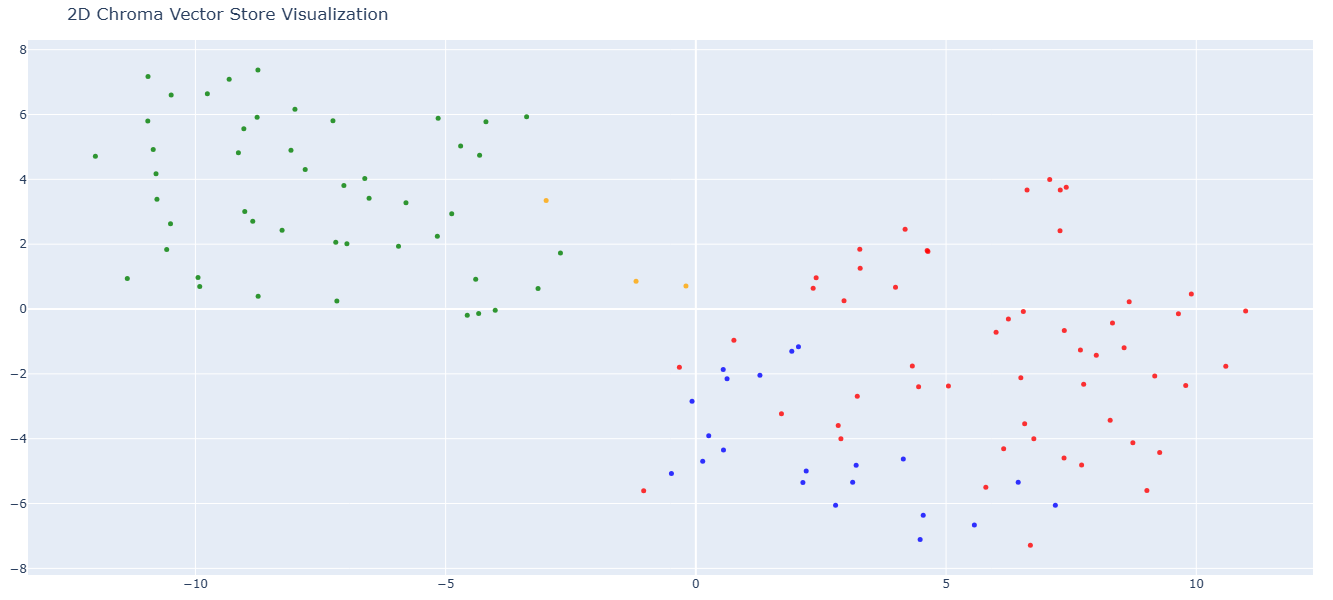

In [14]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

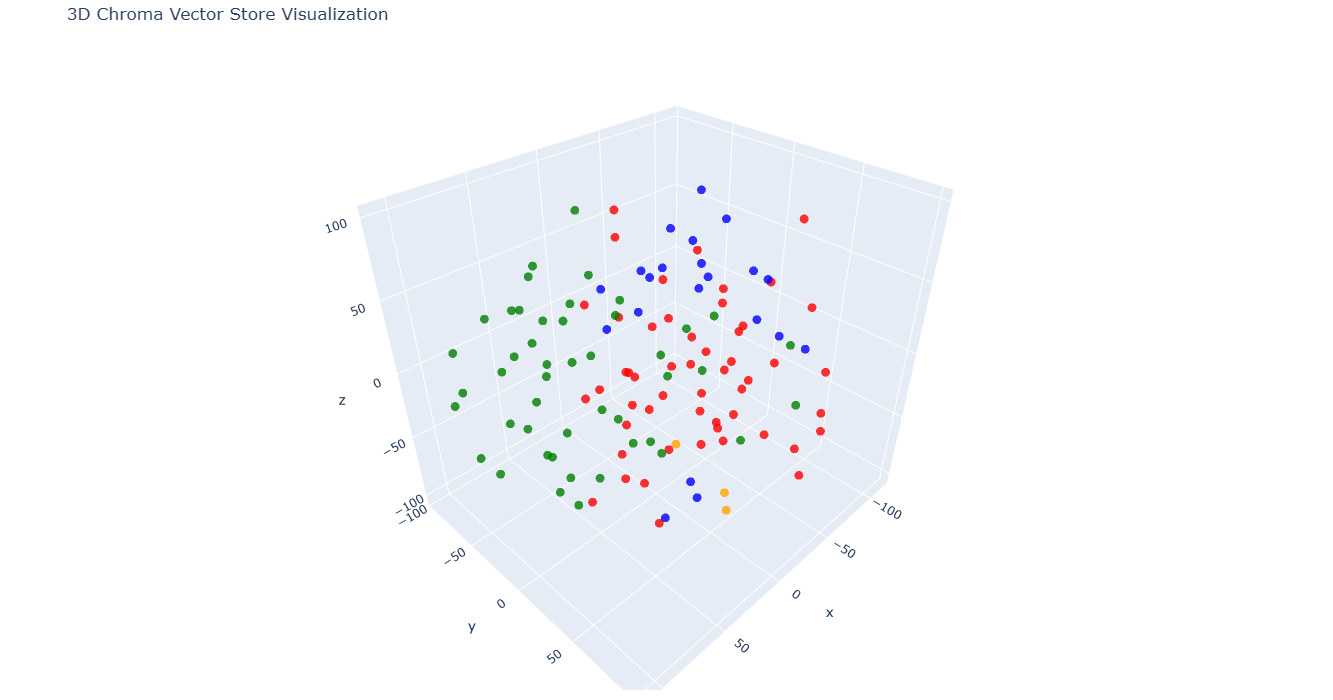

In [15]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [16]:
pip install -U class langchain-ollama


Note: you may need to restart the kernel to use updated packages.


In [17]:
from langchain_ollama import ChatOllama

In [18]:
llm = ChatOllama(model = MODEL)

In [19]:
memory = ConversationBufferMemory(
    memory_key = 'chat_history',
    return_messages = True
)

C:\Users\athar\AppData\Local\Temp\ipykernel_21068\3571910578.py:1: LangChainDeprecationWarning:

Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/



In [20]:
retriever = vectorstore.as_retriever()

In [21]:
conversational_chain = ConversationalRetrievalChain.from_llm(
    llm = llm,
    retriever = retriever,
    memory = memory
)

In [22]:
query = "Can you describe what is Insurellm in a few sentences"
result = conversational_chain.invoke({"question":query})
print(result["answer"])

Insurellm is an innovative insurance tech firm that offers four software products: Carllm, Homellm, Rellm, and Marketllm. The company has more than 300 clients worldwide and reached 200 employees across the US by 2024 with 12 offices. Insurellm aims to disrupt the industry through its cutting-edge technology solutions, such as AI-powered risk assessment and dynamic pricing models.


In [23]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [24]:
# Wrapping in a function - note that history isn't used, as the memory is in the conversation_chain

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [25]:
# And in Gradio:

view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [26]:
from langchain_core.callbacks import StdOutCallbackHandler

llm = ChatOllama(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever()

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

query = "Who received the prestigious IIOTY award in 2023?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)

ValidationError: 1 validation error for ChatOllama
model
  Field required [type=missing, input_value={'temperature': 0.7, 'model_name': 'llama3.2'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing